# Train a policy using RL

In this notebook, we train a policy using RL to navigate among other agents controlled by navground. We start by defining the same setup as in the introductory "Gym" notebook. As SB3 `SAC` requires flat observartion spaces, we specify it in `ObservationConfig`.

In [1]:
import gymnasium as gym
import numpy as np
from navground import sim
from navground.sim.ui.video import display_video
from navground_learning import ControlActionConfig, ObservationConfig
from navground_learning.reward import SocialReward
from navground_learning.env import NavgroundEnv

import warnings
warnings.filterwarnings('ignore')

sensor = sim.load_state_estimation("""
type: Discs
number: 5
range: 5.0
max_speed: 0.12
max_radius: 0.1
""")

scenario = sim.load_scenario("""
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: gray
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.1
    state_estimation:
      type: Bounded
      range: 5.0
""")

duration = 60.0
time_step = 0.1

env = gym.make('navground',
    scenario=scenario,
    sensor=sensor,
    action=ControlActionConfig(),
    observation=ObservationConfig(flat=True),
    reward=SocialReward(),
    time_step=time_step,
    render_mode="rgb_array",
    max_duration=duration);

and function to collect and plot the rewards for both types of agents and make a video from a run

In [2]:
from navground.sim.ui.video import display_video
from navground_learning.behaviors import PolicyBehavior
from navground_learning.evaluate import make_experiment_with_env
from matplotlib import pyplot as plt

def display_run(policy, seed=0, factor=10):
    world = sim.World()
    scenario.init_world(world, seed=seed)
    agent=world.agents[env.unwrapped.agent_index]
    agent.behavior = PolicyBehavior.clone_behavior(
        agent.behavior, policy=policy, action_config=env.action_config, 
        observation_config=env.observation_config)
    agent.state_estimation = sensor
    agent.color = 'red'
    return display_video(
        world=world, time_step=0.1, duration=120.0, factor=factor, display_width=300)

def plot_run_reward(policy=None, steps=20000, seed=0):
    experiment = make_experiment_with_env(env.unwrapped, policy=policy, steps=steps, reward=env.unwrapped.reward)
    experiment.number_of_runs = 1
    experiment.run_index = seed
    experiment.run()
    rewards = np.asarray(experiment.runs[seed].get_record("reward"))
    plt.hist(rewards[:, 1:].flatten(), density=True, 
                 color='black', alpha=0.5, bins=30, 
                 label=f"Agents with original behavior")
    plt.hist(rewards[:, 0], density=True, 
                 color='red', alpha=0.5, bins=30,
                 label=f"Agent with policy");
    plt.title(f'Reward distribution')
    ax = plt.gca()
    ax.set_yticks([])
    ax.yaxis.set_tick_params(labelleft=False)
    plt.xlabel("reward")
    plt.ylabel("probability")
    plt.legend()

## RL learning

In [3]:
from stable_baselines3 import SAC

model = SAC("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=10000, progress_bar=True);

Output()

In [4]:
from stable_baselines3.common.evaluation import evaluate_policy

reward_mean, reward_std_dev = evaluate_policy(model,  model.get_env(), 30)

total_steps = duration / time_step
reward_mean /= total_steps
reward_std_dev /= total_steps
print(f"Reward: {reward_mean:.3f} ± {reward_std_dev:.3f}")

Reward: -0.330 ± 0.098


In [5]:
display_run(model.policy)

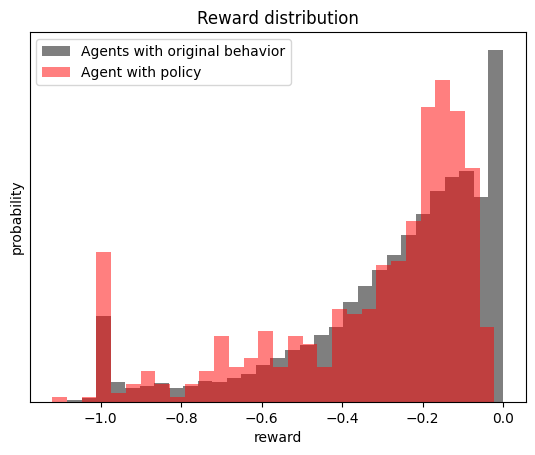

In [6]:
plot_run_reward(model.policy)